### Goal
The goal of this notebook is to show how a bayesian latent class analysis can be carried out using pymc and MCMC. 

### Data
There are two datasets to explore (generated in the generate_data.ipynb notebook). Here the second dataset will be modeled with LCA. The second dataset is a bit more complex. Three underlying groups generate a multivariate dataset (1000 samples from each group). Each sample has the following structure: x1 and x2 are normally distributed and x3 is Poisson distributed. There is significant overlap between groups when looking at one or two variables at a time, looking at all three, it should be possible to group the data properly. See the other notebook for visualizations of the datasets.

### Model structure
Assumptions about the number of groups and distributions of emission variables will be made. The latter with weak priors. Model comparison will be carried out using PSIS-LOO or WAIC.

In [12]:
#Import libraries
import pymc as pm
import pandas as pd
import arviz as az
import numpy as np
import seaborn as sns

In [13]:
#Load data
dataset_2 = pd.read_csv("dataset_2.csv", index_col=0)

In [14]:
#The observed variables
data = dataset_2[["x1", "x2", "x3"]]

In [15]:
#Define the k_values we are going to test (aside from k=1) and the traces dict for storage of inference data
k_values = [2, 3, 4, 5]
traces = {}

In [16]:
#one class model
with pm.Model() as model_1:
    #Priors
    mu1 = pm.Normal("mu1", 0, 5)
    sigma1 = pm.HalfNormal("sigma1", 5)

    mu2 = pm.Normal("mu2", 0, 5)
    sigma2 = pm.HalfNormal("sigma2", 5)

    lam3 = pm.HalfNormal("lam3", 5)

    #Likelihood
    pm.Normal("likelihood1", mu1, sigma1, observed=data.x1)
    pm.Normal("likelihood2", mu2, sigma2, observed=data.x2)
    pm.Normal("likelihood3", lam3, observed=data.x3)

    trace_1 = pm.sample(draws=1000, chains=2, return_inferencedata=True, idata_kwargs = {'log_likelihood': True})


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


In [17]:
#Calculate joint probability of the three emission likelihood functions and store it in the inference data object
log_lik = trace_1.log_likelihood
log_lik["joint_likelihood"] = (("chain", "draw", "joint_likelihood_dim_0"), log_lik.likelihood1.values + log_lik.likelihood2.values + log_lik.likelihood3.values)

In [18]:
#Store the inference data for the one class model in the traces dictionary
traces["1_class_model"] = trace_1

In [19]:
#Run the k>1 class models, calculate the joint likelihood and save the inference data in the trace dict

for k in k_values:
    with pm.Model() as model_2:
        #Emission parameter priors
        mu1 = pm.Normal("mu1", 0, 5, size=k)
        sigma1 = pm.HalfNormal("sigma1", 5, size=k)

        mu2 = pm.Normal("mu2", 0, 5, size=k)
        sigma2 = pm.HalfNormal("sigma2", 5, size=k)

        lam3 = pm.HalfNormal("lam3", 5, size=k)

        #Latent class probability prior
        p = pm.Dirichlet("p", np.ones(k))

        #Latent class assignment prior
        z = pm.Categorical("z", p, shape=len(data))

        #Likelihood functions
        pm.Normal("likelihood1", mu1[z], sigma1[z], observed=data.x1)
        pm.Normal("likelihood2", mu2[z], sigma2[z], observed=data.x2)
        pm.Normal("likelihood3", lam3[z], observed=data.x3)

        #Inference time
        trace_k = pm.sample(draws=1000, chains=2, return_inferencedata=True, idata_kwargs = {'log_likelihood': True})

        #Calculate joint likelihood + store
        log_lik = trace_k.log_likelihood
        log_lik["joint_likelihood"] = (("chain", "draw", "joint_likelihood_dim_0"), log_lik.likelihood1.values + log_lik.likelihood2.values + log_lik.likelihood3.values)

        traces[f"{k}_class_model"] = trace_k

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 339 seconds.


### Model comparison
Let's compare the five models!

/Users/JO/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/JO/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/JO/miniforge3/envs/pymc_env/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/JO/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated sha

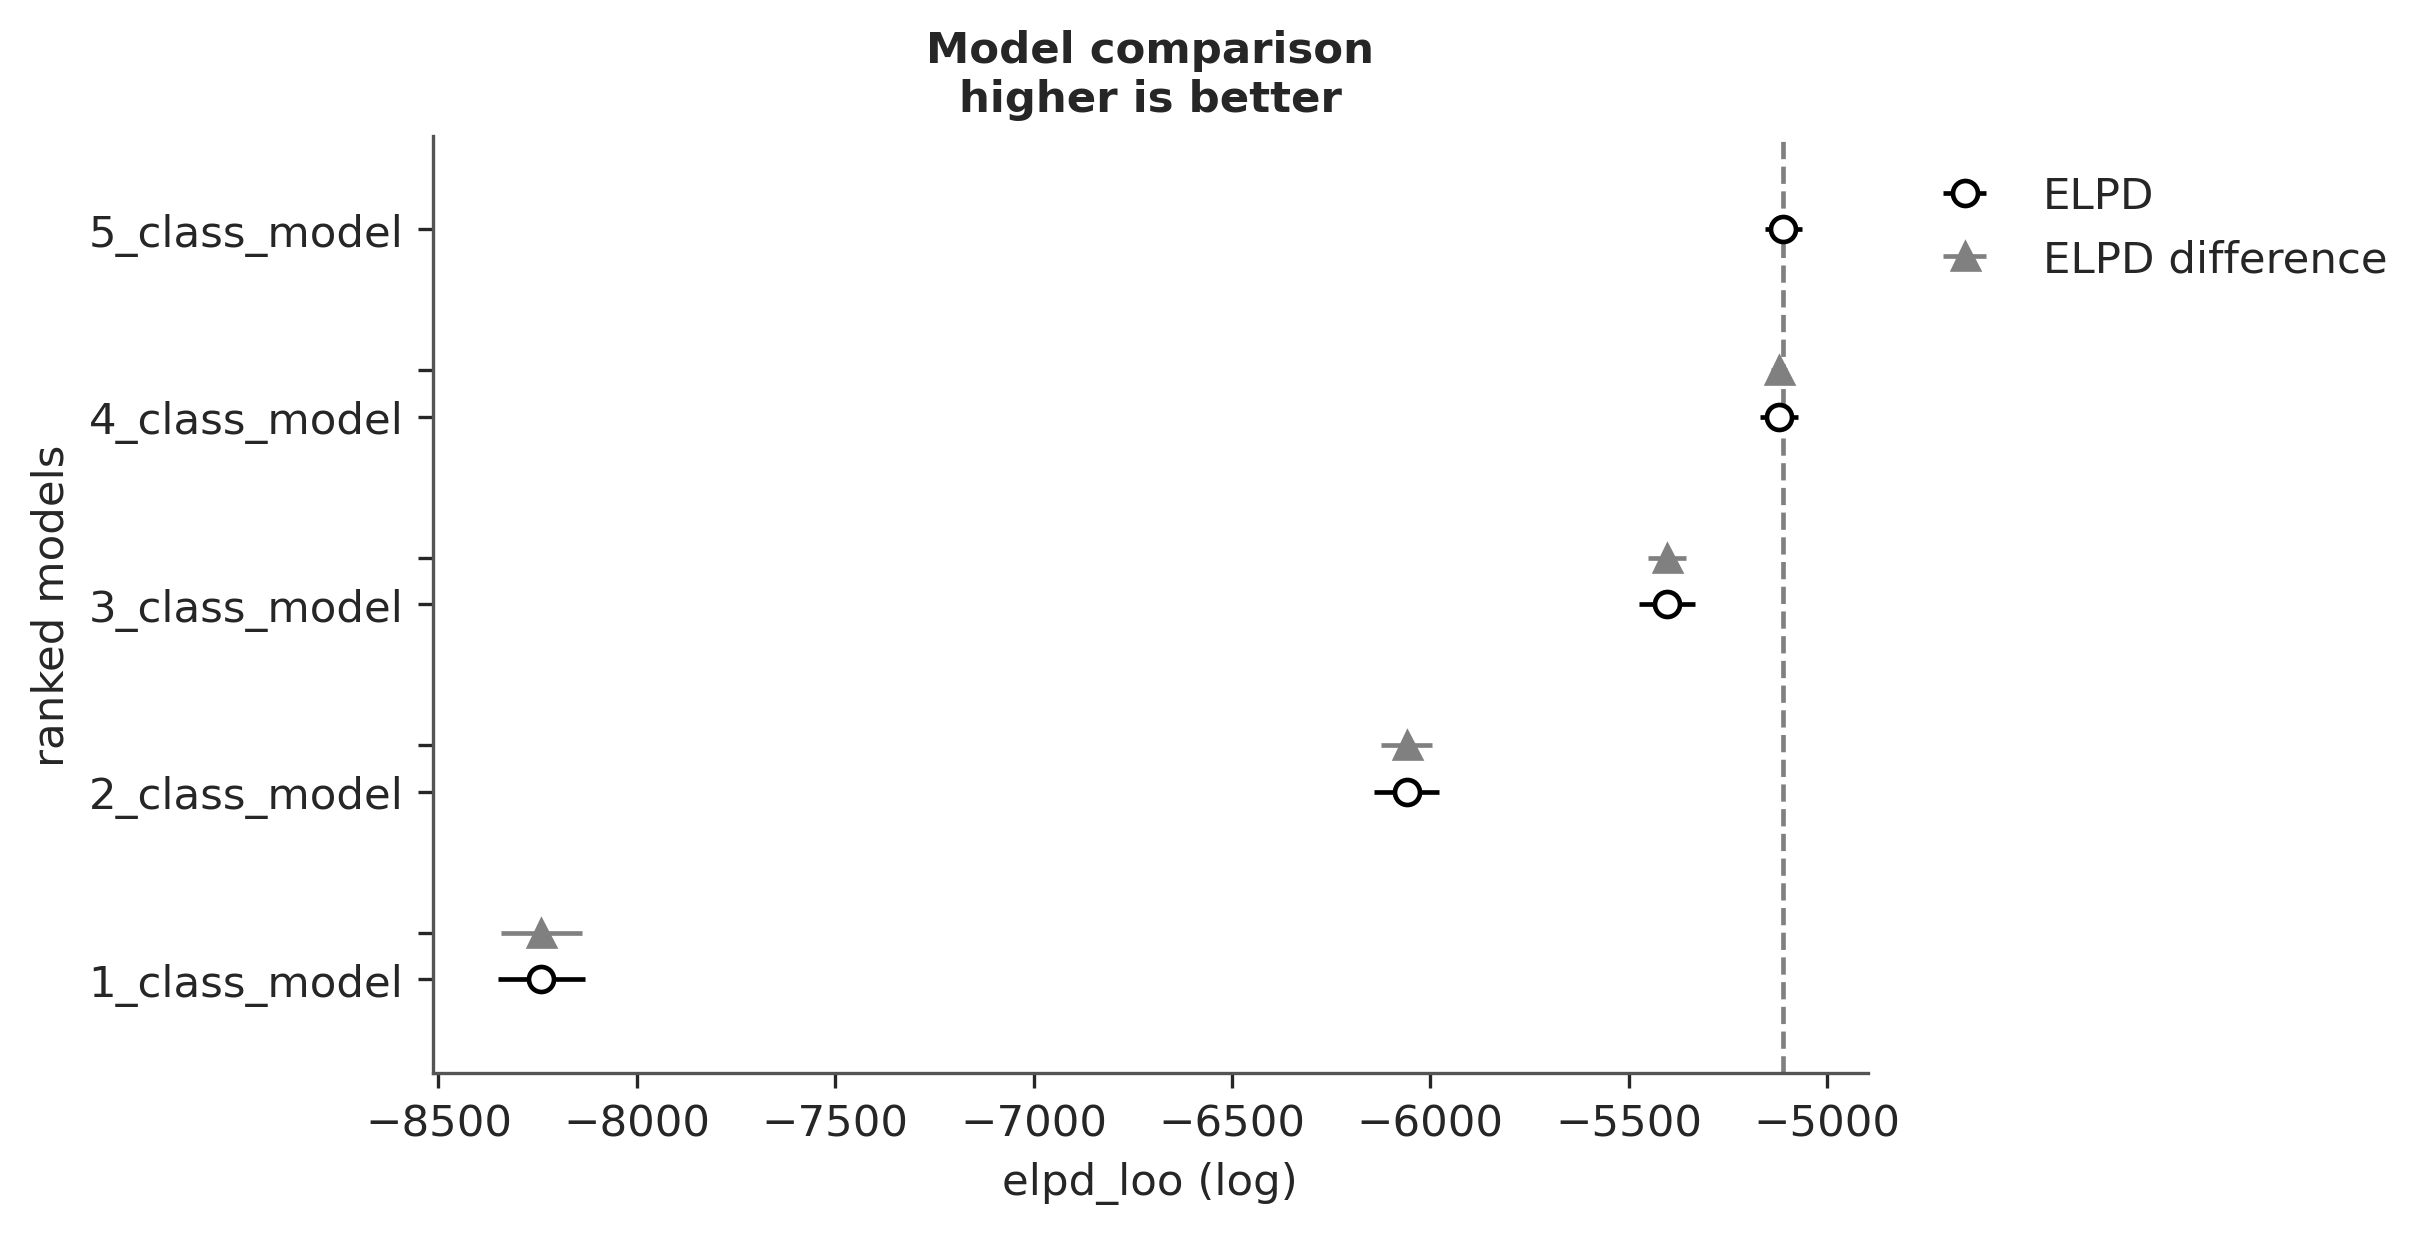

In [20]:
#Compare w/ PSIS-LOO
comparison = az.compare(traces, ic="loo", var_name="joint_likelihood")
az.style.use("arviz-doc")
az.plot_compare(comparison, figsize=(8,4));

Again, the more classes - the better the score. Let's look at the traces for the 3 and 4 class models. We see that the "superflous" class in the four class model is moving all over the place. Also, we see that there is label shifting between chains.

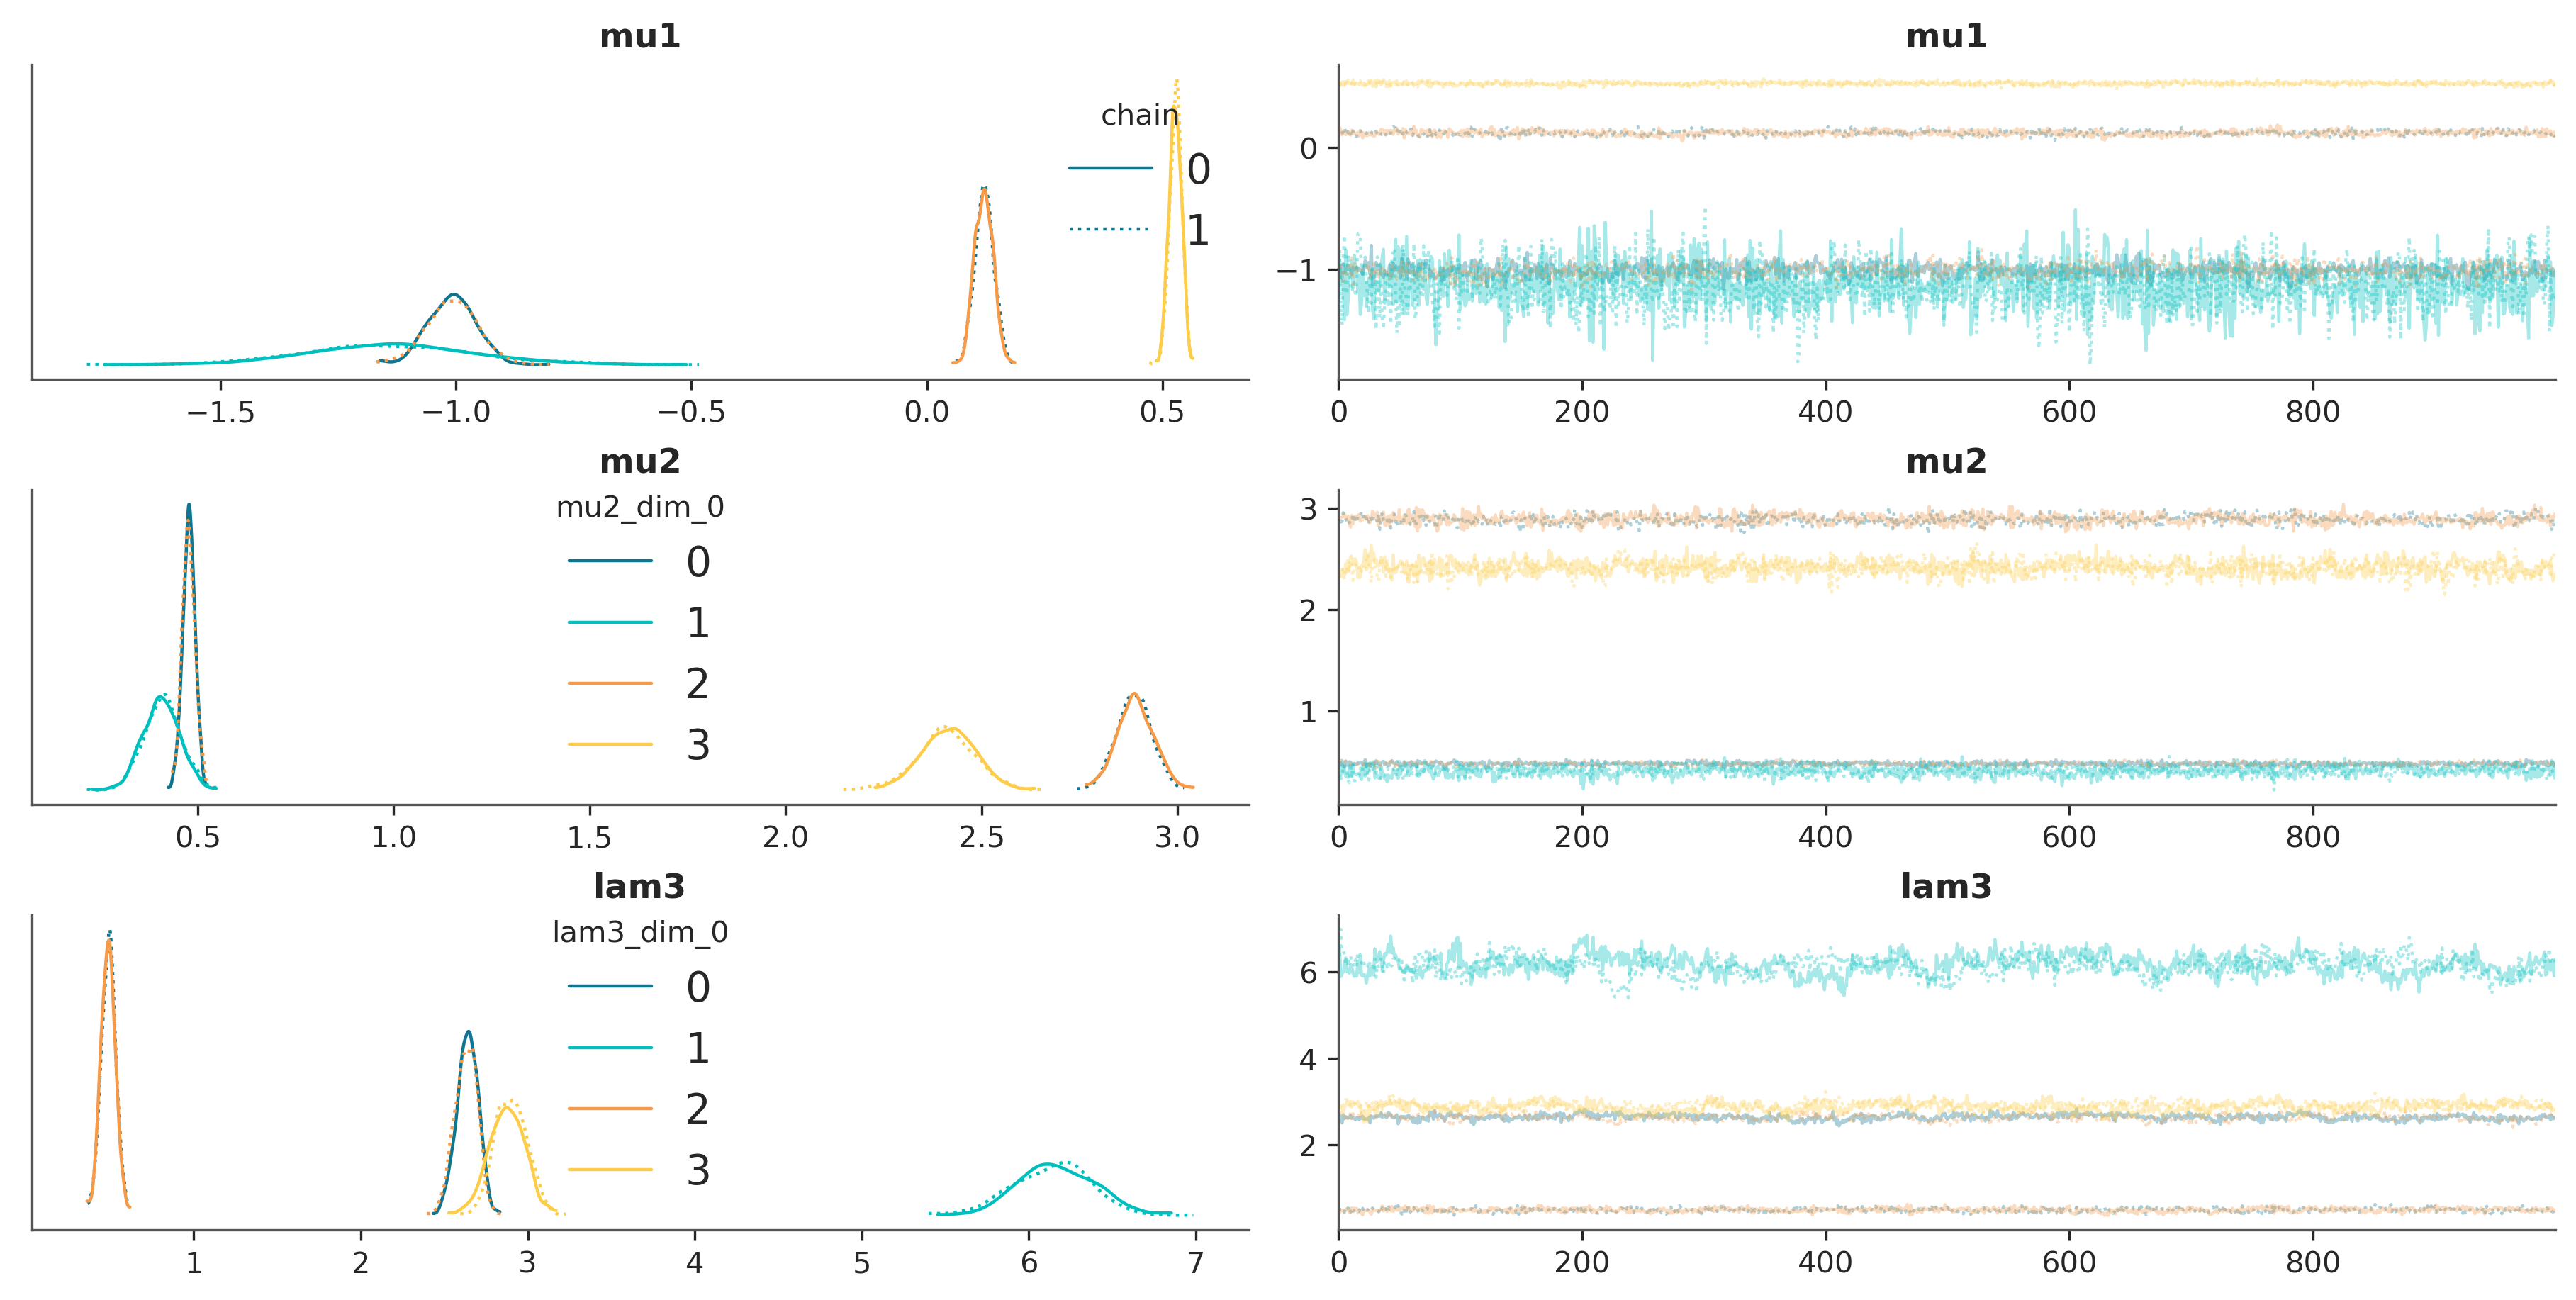

In [80]:
az.plot_trace(traces["4_class_model"], var_names=["mu1", "mu2", "lam3"], legend=True);

Further, all models but the one class model are yielding warnings in the PSIS-LOO estimation due to (many) highly influential values. Let's take a look specifically at the (correct) three class model.

In [46]:
loo_3class = az.loo(traces["3_class_model"], var_name="joint_likelihood", pointwise=True)
loo_3class

/Users/JO/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/JO/miniforge3/envs/pymc_env/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/JO/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 1500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5403.31    70.59
p_loo      315.57        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      914   60.9%
 (0.5, 0.7]   (ok)         79    5.3%
   (0.7, 1]   (bad)        96    6.4%
   (1, Inf)   (very bad)  411   27.4%

Around 1/3 of the observations are causing trouble. Let's see if we can figure out which observations are causing this issue.

In [78]:
#Create a dataframe with information about unexpected observations
unexpected_observations = loo_3class.pareto_k.values >= 0.7
dataset_2_psis = dataset_2.copy()
dataset_2_psis["unexpected_observations"] = unexpected_observations

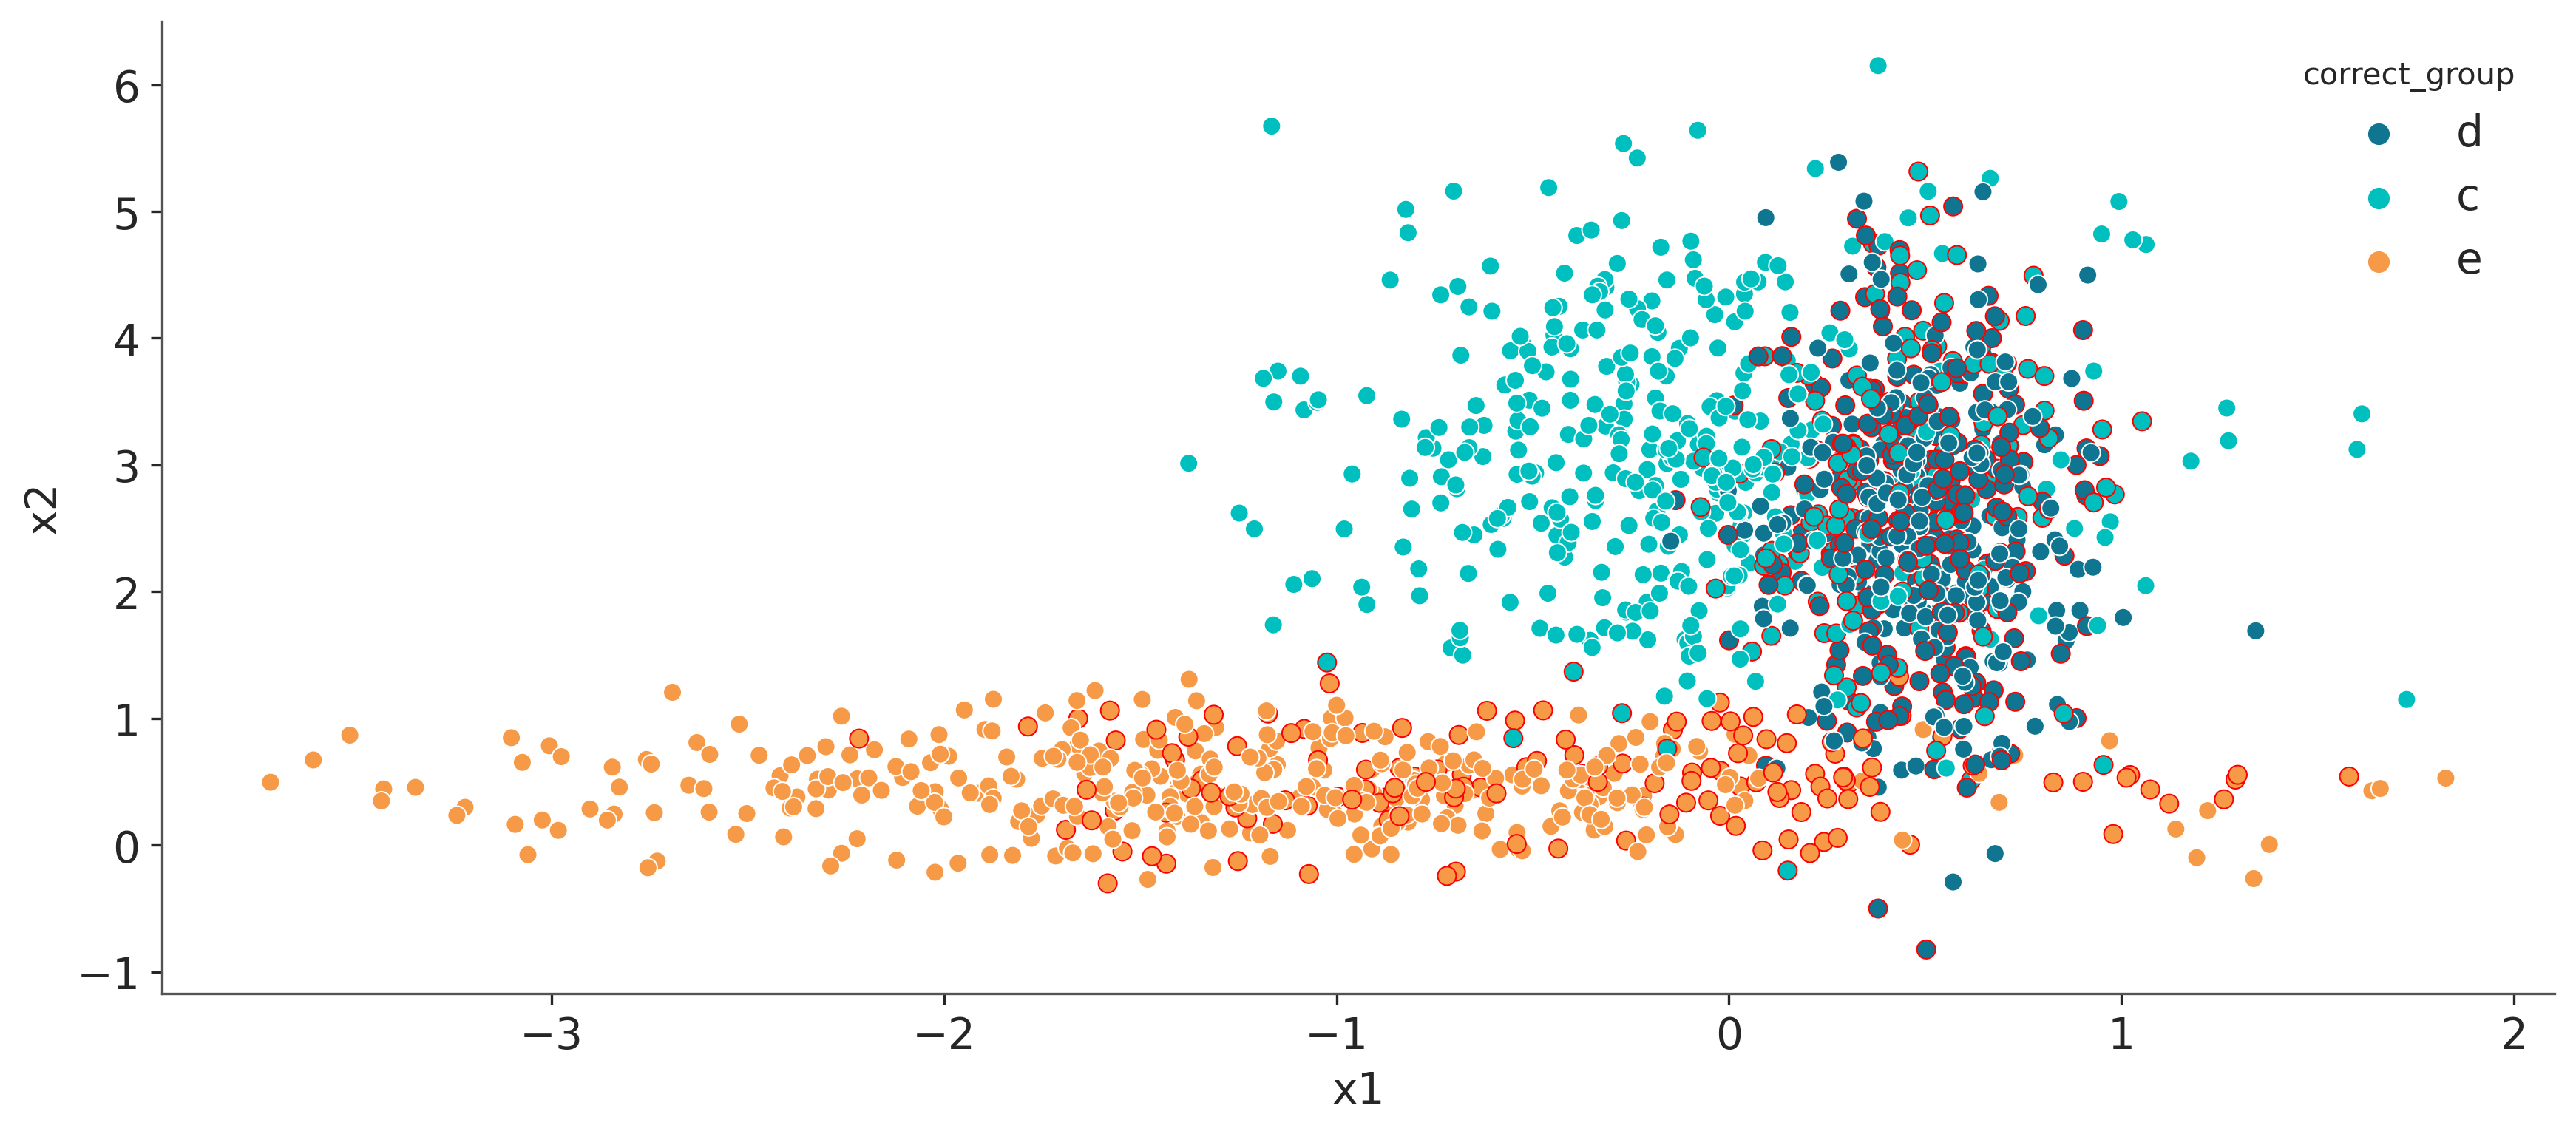

In [79]:
#Plot x1 and x2 values in a scatterplot. Hue is the correct group. Red edges are unexpected observations in the PSIS-LOO procedure.
sns.scatterplot(x=dataset_2.x1,
                y=dataset_2.x2,
                hue=dataset_2.correct_group,
                edgecolor=np.where(dataset_2_psis.unexpected_observations, 'red', 'white')
                );

It's really hard to make anything out of this visual representation of a 4-dimensional space. However, could the problem possibly be because of label switching? The true means for x1 are c=0, d=0.5, e=-1 and for x2 c=3, d=2.5, e=0.5. Let's look at the MCMC chains again.


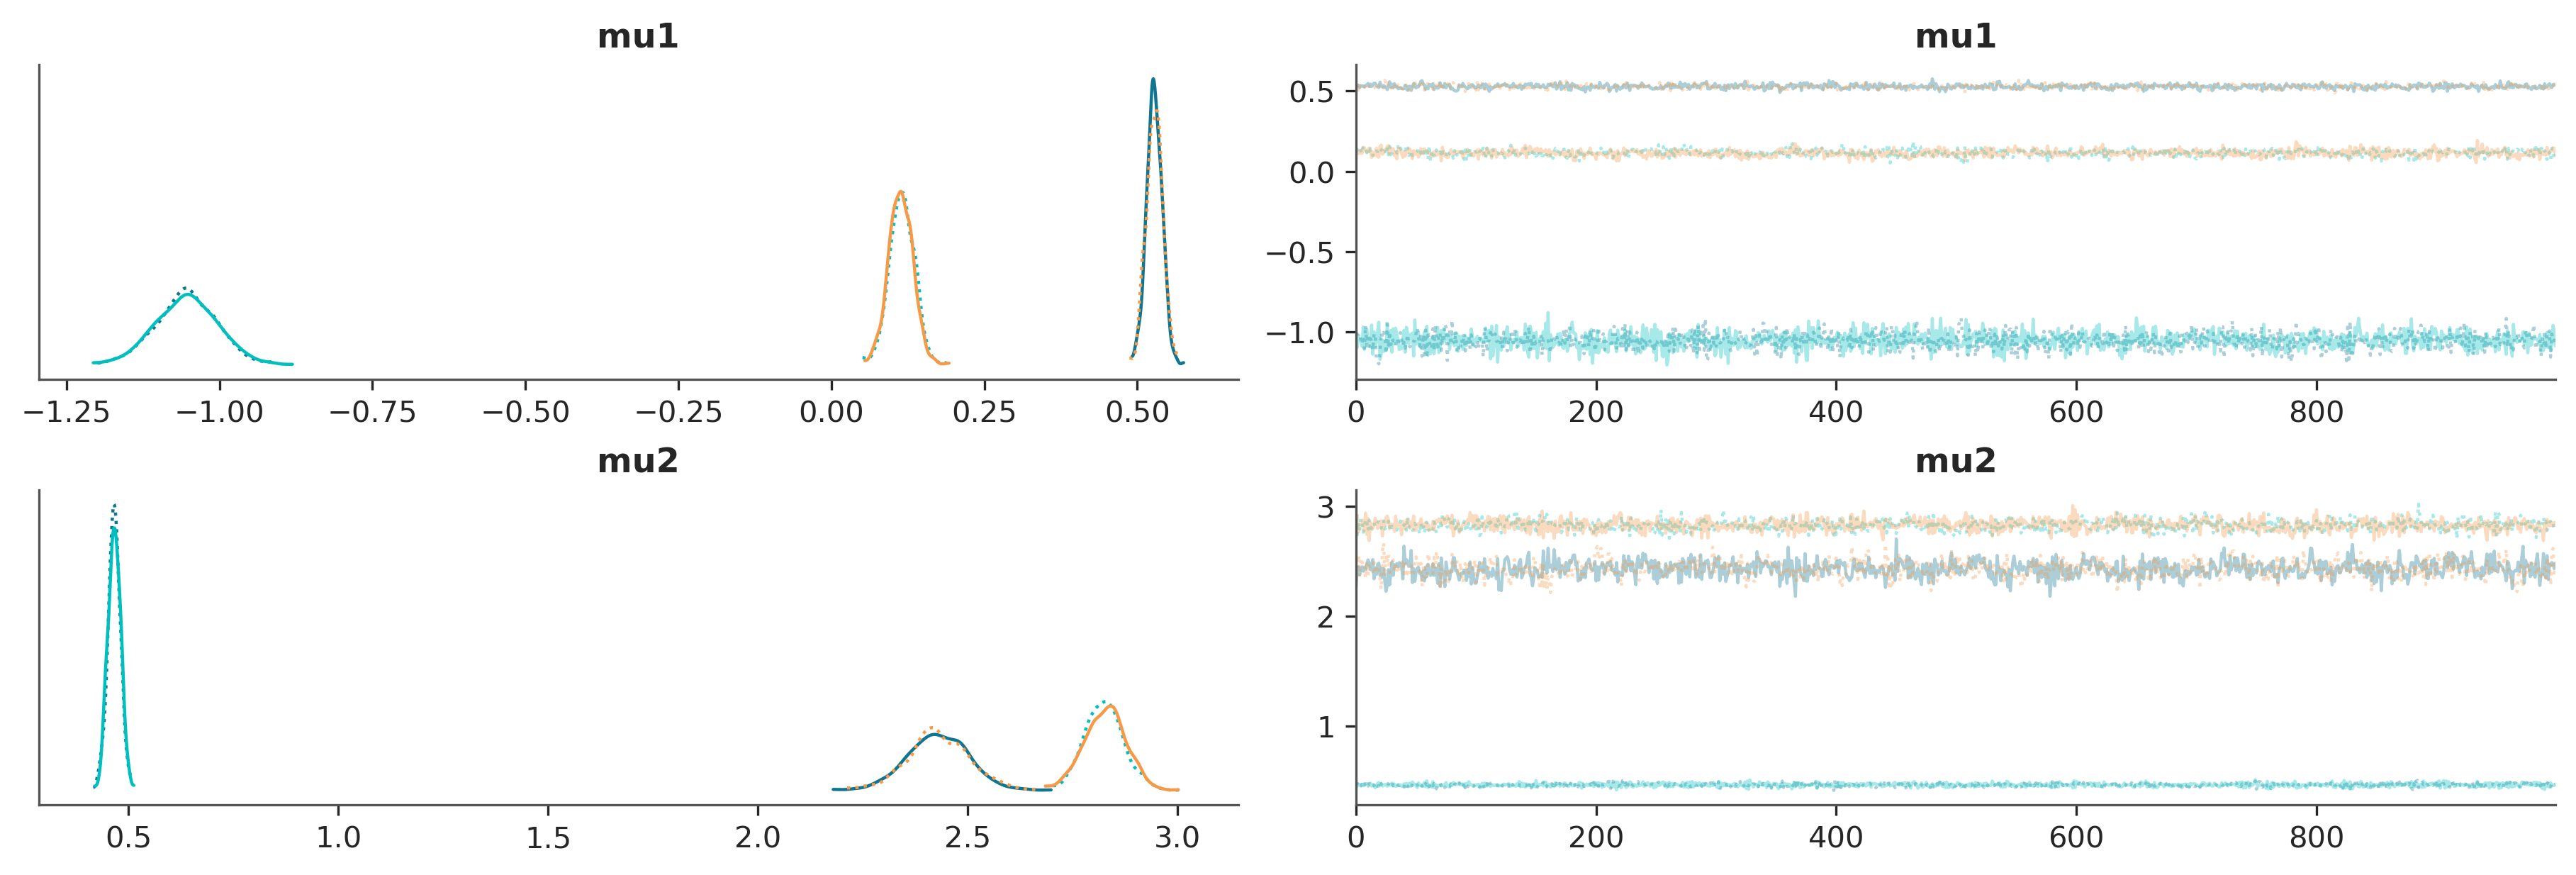

In [83]:
az.plot_trace(traces["3_class_model"], var_names=["mu1", "mu2"]);

So, what happens if we run only one chain during inference? We will of course not have the problem of label switching within each model. Let's try a three class model.

In [108]:
#three class model
with pm.Model() as model_2_one_chain:
    k = 3
    #Emission parameter priors
    mu1 = pm.Normal("mu1", 0, 5, size=k)
    sigma1 = pm.HalfNormal("sigma1", 5, size=k)

    mu2 = pm.Normal("mu2", 0, 5, size=k)
    sigma2 = pm.HalfNormal("sigma2", 5, size=k)

    lam3 = pm.HalfNormal("lam3", 5, size=k)

    #Latent class probability prior
    p = pm.Dirichlet("p", np.ones(k))

    #Latent class assignment prior
    z = pm.Categorical("z", p, shape=len(data))

    #Likelihood functions
    pm.Normal("likelihood1", mu1[z], sigma1[z], observed=data.x1)
    pm.Normal("likelihood2", mu2[z], sigma2[z], observed=data.x2)
    pm.Normal("likelihood3", lam3[z], observed=data.x3)

    #Inference time
    trace_3_one_chain = pm.sample(draws=1000, chains=1, return_inferencedata=True, idata_kwargs = {'log_likelihood': True})

    #Calculate joint likelihood + store
    log_lik_one_chain = trace_3_one_chain.log_likelihood
    log_lik_one_chain["joint_likelihood"] = (("chain", "draw", "joint_likelihood_dim_0"), log_lik_one_chain.likelihood1.values + log_lik_one_chain.likelihood2.values + log_lik_one_chain.likelihood3.values)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 319 seconds.
/Users/JO/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Let's check the PSIS-LOO and it's diagnostics.

In [110]:
loo_3class_one_chain = az.loo(trace_3_one_chain, var_name="joint_likelihood", pointwise=True)
loo_3class_one_chain

/Users/JO/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 1500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5410.20    70.45
p_loo      323.96        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      940   62.7%
 (0.5, 0.7]   (ok)         49    3.3%
   (0.7, 1]   (bad)        79    5.3%
   (1, Inf)   (very bad)  432   28.8%

Nope, still potentially messed up PSIS-LOO. Let's take a look at the data again.

In [111]:
unexpected_observations_one_chain = loo_3class_one_chain.pareto_k >= 0.7

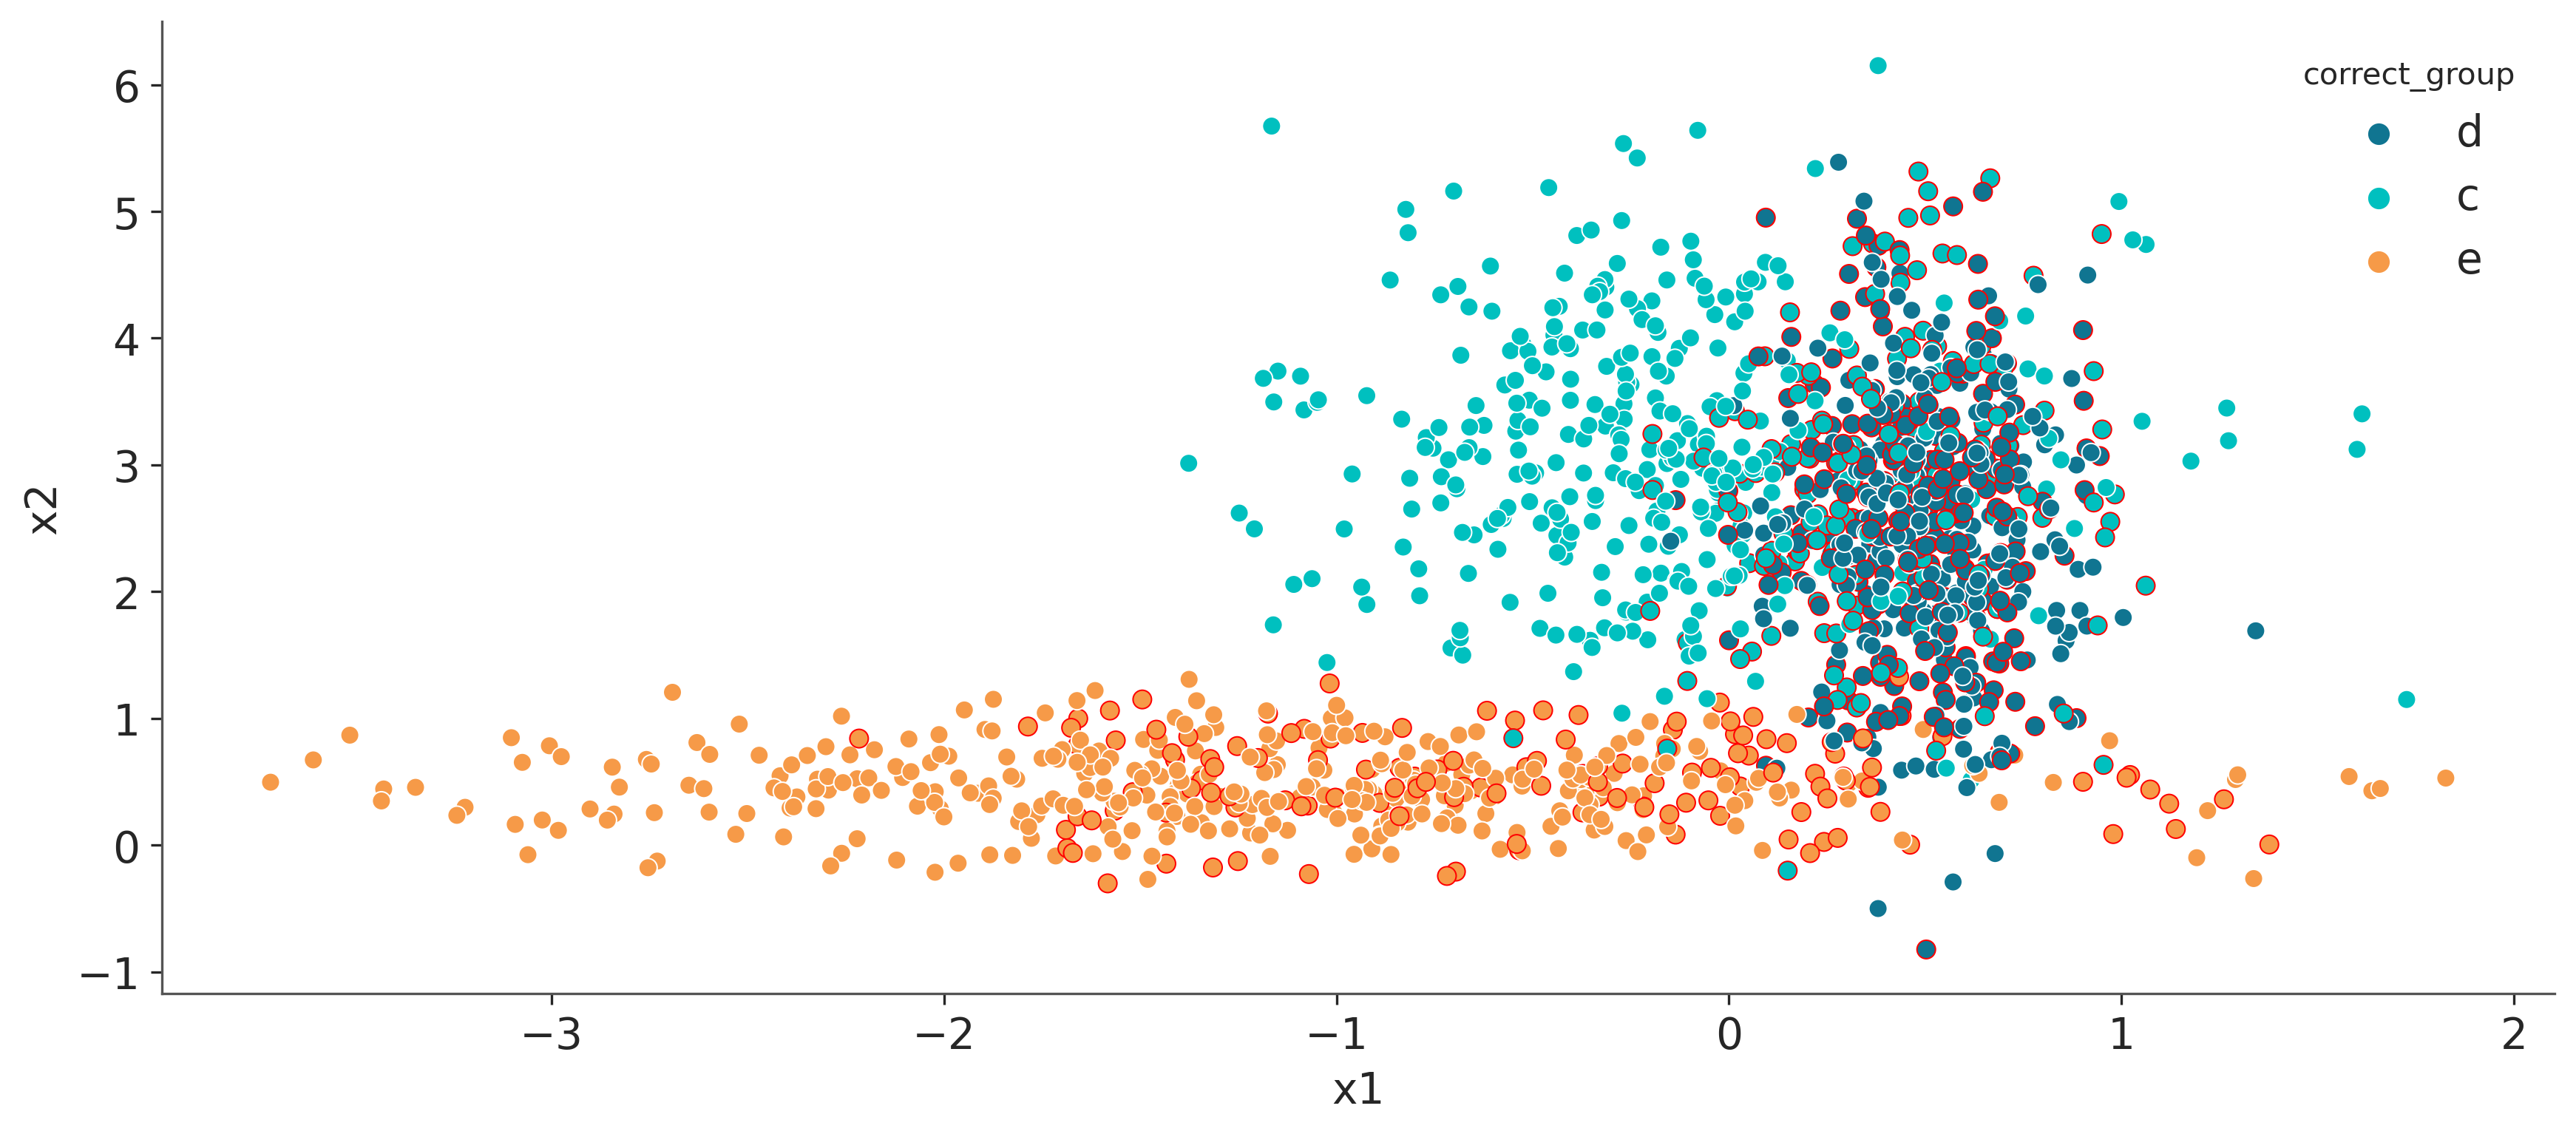

In [112]:
#Plot x1 and x2 values in a scatterplot. Hue is the correct group. Red edges are unexpected observations in the PSIS-LOO procedure.
sns.scatterplot(x=dataset_2.x1,
                y=dataset_2.x2,
                hue=dataset_2.correct_group,
                edgecolor=np.where(unexpected_observations_one_chain, 'red', 'white')
                );

The fact that model switching is not the (sole) cause of the PSIS-warning makes sense. Looking at the defintion of PSIS-LOO, it seems as if MCMC chains are treated "separately". Perhaps it's the (inevitable) overlap between groups that is the issue? One could of course run proper CV for the models and then to the comparison. The problem is not PSIS-LOO, the problem is that the model does not allow PSIS-LOO to work. Proper cross validation comes at a computational cost and will be tested in a separate notebook. Another option would be to incorporate k as a parameter in the model.